# APS DSECOP Module #4 dataset generation

This script generates a set of $pp \rightarrow X(\rightarrow ab)cd$ events. We assume that particles $a$ and $c$ have a charge of $+1$ and particles $b$ and $d$ have a charge of $-1$.

Steps:

- Use $\texttt{ROOT.TGenPhaseSpace()}$ to generate the decay

- Simulate the detector inefficiency by adding a random "jitter" to the daughter particle 4-momenta

- Output the daughter momenta (in a random order) to a .txt file


In [5]:
# imports

import ROOT 
import ROOT.TMath as rm
from array import array
import numpy as np
import matplotlib.pyplot as plt

First, a function to simulate the resonant decay.

Note: the $\texttt{ROOT.TGenPhaseSpace()}$ class gives each decay a weight. For now, we're going to pretend all of the weights are 1. This will slightly change the output distributions from what is physically correct, but not so much that we can't do a realistic fit to an invariant mass distribution.

In [3]:
def simulateResonantDecay(m_X, m_products, COM_energy, randomSeed=-1):
    
    """
    INPUTS:
    
    m_X: float of the mass of the resonant particle X in GeV
    
    m_products: array [m_a, m_b, m_c, m_d] containing floats of the mass of the daughter particles in GeV
    
    COM_energy: float of the COM collision energy in GeV
    
    **********
    **********
    
    OUTPUTS: 
    
    p4_a, p4_b, p4_c, p4_d: ROOT.TLorentzVectors for the daughter particles
    
    """
    
    [m_a, m_b, m_c, m_d] = m_products
    
    # The initial collision energy, in the COM frame 
    p4_init = ROOT.TLorentzVector(0, 0, 0, COM_energy) 
    weight = 1.0
    
    if (randomSeed >= 0):
        ROOT.gRandom.SetSeed(randomSeed)
           
    # Create the first TGenPhaseSpace class
    # This is for the decay pp -> Xcd
    event = ROOT.TGenPhaseSpace()
    daughters_array = array("d",[m_X, m_c, m_d])
    passed = event.SetDecay(p4_init, 3, daughters_array)
    if not passed:
        print("ERROR: Decay Failed")
    weight = event.Generate()
    
    # Get the daughter particles
    p4_X = event.GetDecay(0)
    p4_c = event.GetDecay(1)
    p4_d = event.GetDecay(2)
    
    # Create the second TGenPhaseSpace class
    # This is for the decay X -> ab
    eventX = ROOT.TGenPhaseSpace()
    daughters_array = array("d",[m_a, m_b])
    passed = eventX.SetDecay(p4_X, 2, daughters_array)
    if not passed:
        print("ERROR: Decay Failed")
    # simulate the decay
    weightX = eventX.Generate()
    
    # Get the daughter particles
    p4_a = eventX.GetDecay(0)
    p4_b = eventX.GetDecay(1)
    
    
    return p4_a, p4_b, p4_c, p4_d



Now a function to simulate the detector response (and a function to quickly convert from $\texttt{ROOT.TLorentzVector}$ to an array.

The detector is lossy, so it will always reduce the absolute value of the 4-momentum component. 

In [27]:
def simulateDetector(p4_vec, loss = 0.005):
    
    """
    INPUTS:
    
    p4_vec: array [E, px, py, pz] containing floats of 4-momenta components in GeV
    
    **********
    **********
    
    OUTPUTS: 
    
    detected_p4_vec: array [E, px, py, pz] containing floats of the "detected" 4-momenta components in GeV
    
    """
    
    detector_loss = 1.0 - np.abs(np.random.normal(0,loss,4))
    
    detected_p4_vec = [detector_loss[i]*p4_vec[i]for i in range(4)]
    
    return detected_p4_vec
   

def TLorentzToList(p4_vec):
    
    """
    INPUTS:
    
    p4_vec: a ROOT.TLorentzVec
    
    **********
    **********
    
    OUTPUTS: 
    
    p4_list: list [E, px, py, pz] containing floats of the 4-momenta components 
    
    """
    
    return [p4_vec.E(), p4_vec.Px(), p4_vec.Py(), p4_vec.Pz()]
    
    

Now run the simulution (bare decay + detector) and output the daughter particles to a file in randomized order,

Feel free to modify the particle masses, COM energy, or detector lossiness.

In [77]:
#now we run the simulation

outfile_path = "test.txt"


def run_simuluation_and_write(mass_X, m_daughters, COM_energy, loss, NInteractions, outfile_loc):

        #set the seed
        ROOT.gRandom.SetSeed(123)
        
        with open(outfile_loc, "w") as outfile:
            outfile.write("E px py pz charge\n\n")
           

            for i in range(NInteractions):
                
                if i % 1000 == 0:
                    print ("On decay", i)
                
                # Simulate the decay
                p4_a, p4_b, p4_c, p4_d = simulateResonantDecay(mass_X, m_daughters, COM_energy)
                
                # Convert the TLorentzVecs to lists and simulate the detector loss
                p4_a = simulateDetector(TLorentzToList(p4_a),loss)
                p4_b = simulateDetector(TLorentzToList(p4_b),loss)
                p4_c = simulateDetector(TLorentzToList(p4_c),loss)
                p4_d = simulateDetector(TLorentzToList(p4_d),loss)
                
                ordered_particles = {0:p4_a, 1:p4_b, 2:p4_c, 3:p4_d}
                
                # Write out the events in a random order
                outfile.write("<event>\n")
                
                line = ""
                
                order = [0,1,2,3]    
                np.random.shuffle(order)
                
                for o in order: 
                    if o % 2 == 0: # positively charged particle
                        charge = +1
                    else: 
                        charge = -1
                    line += (str(ordered_particles[o][0]) + " " + str(ordered_particles[o][1]) + " " + str(ordered_particles[o][2]) + " " + str(ordered_particles[o][3]) + " " + str(charge) + "\n")
              
                    
                outfile.write(line)
    
                outfile.write("</event>\n")
                outfile.write("\n")
            
            print("Output file written to", outfile_loc)


    
NInteractions = 10000
mass_X = 2.632 # GeV 
m_daughters = [.7,.2,.6,.3]

COM_energy = 5
loss = 0.08

run_simuluation_and_write(mass_X, m_daughters, COM_energy, loss, NInteractions, outfile_path)

On decay 0
On decay 1000
On decay 2000
On decay 3000
On decay 4000
On decay 5000
On decay 6000
On decay 7000
On decay 8000
On decay 9000
Output file written to test.txt


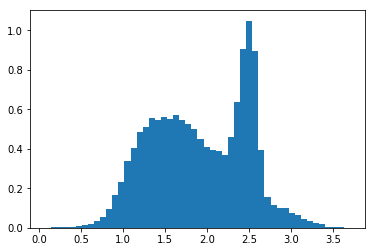